# **INTRODUCTION**
This is the second part of my TTC Subway Delay project.

**Dataset**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import textwrap
import calendar

In [6]:
df_master = pd.read_excel('/Users/emmandeguzman/Documents/Data Projects/TTC Delay Dataset/df_master.xlsx')
df_master

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean,line_clean,datetime,delay_cause,delay_category
0,2024-01-01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491,Sheppard-Yonge,Lines 1 and 4 Shared,2024-01-01 02:00:00,Injured or ill Customer (On Train) - Transported,Passenger Related
1,2024-01-01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0,Dundas,Line 1 Yonge-University,2024-01-01 02:00:00,Injured or ill Customer (In Station) - Transpo...,Passenger Related
2,2024-01-01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051,Dundas,Line 1 Yonge-University,2024-01-01 02:08:00,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
3,2024-01-01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284,Kennedy,Lines 2 and 3 Shared,2024-01-01 02:13:00,Debris At Track Level - Uncontrollable,Fortuitous Event
4,2024-01-01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986,Bloor-Yonge,Lines 1 and 2 Shared,2024-01-01 02:22:00,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214456,2017-04-30,19:50,Sunday,BLOOR DANFORTH SUBWAY,MUO,0,0,NaN,BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 19:50:00,Miscellaneous Other,Undefined
214457,2017-04-30,20:25,Sunday,WARDEN STATION,SUDP,4,8,W,BD,5107,Warden,Line 2 Bloor-Danforth,2017-04-30 20:25:00,Disorderly Patron,Passenger Related
214458,2017-04-30,20:29,Sunday,KEELE STATION,SUROB,0,0,NaN,BD,0,Keele,Line 2 Bloor-Danforth,2017-04-30 20:29:00,Robbery,Passenger Related
214459,2017-04-30,22:00,Sunday,YONGE UNIVERSITY LINE,MUO,0,0,NaN,YU/BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 22:00:00,Miscellaneous Other,Undefined


# **EXPLORATORY DATA ANALYSIS**

## Daily Delay Occurrences

Delay Occurrences is the count or number of recorded delays in a given time period.

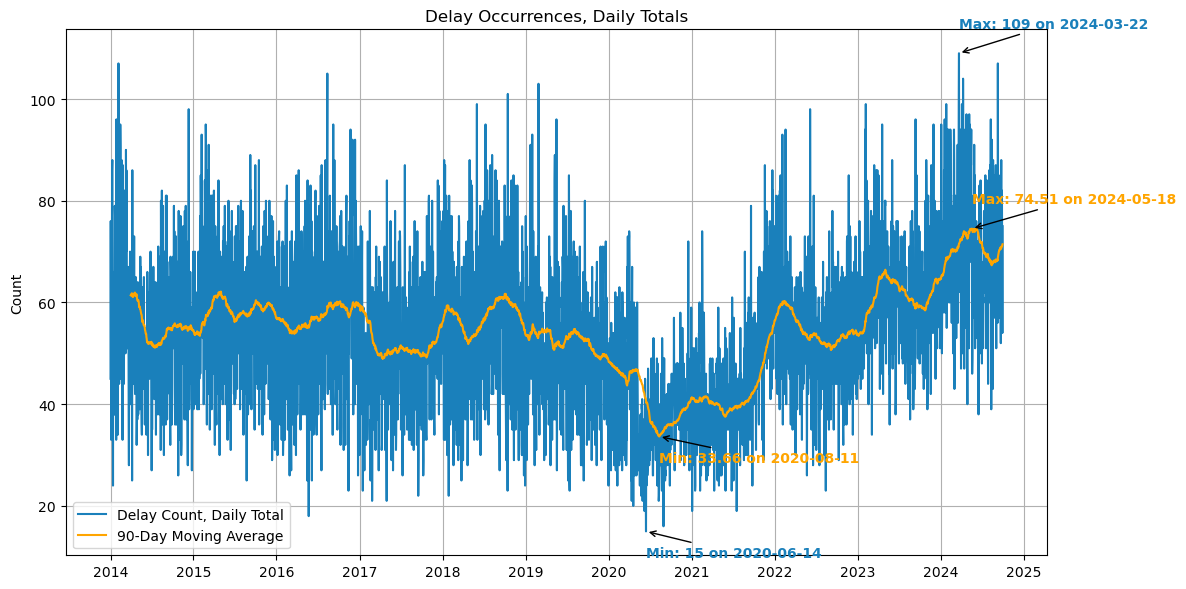

In [10]:
daily_delay_occurrence = df_master.groupby('Date')['Min Delay'].count().reset_index()
daily_delay_occurrence['MA90'] = daily_delay_occurrence['Min Delay'].rolling(window = 90).mean()
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(daily_delay_occurrence['Date'], daily_delay_occurrence['Min Delay'], color='#1a80bb', label='Delay Count, Daily Total')
ax.plot(daily_delay_occurrence['Date'], daily_delay_occurrence['MA90'], label='90-Day Moving Average', color='orange')
ax.set_title('Delay Occurrences, Daily Totals')
ax.set_ylabel('Count')
ax.grid(True)
ax.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# maximum data annotation
max_date = daily_delay_occurrence.loc[daily_delay_occurrence['Min Delay'].idxmax(), 'Date']
max_delay = daily_delay_occurrence['Min Delay'].max()
plt.annotate(f'Max: {max_delay} on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), xytext = (max_date, max_delay + 5),
             arrowprops = dict(arrowstyle = '->'), fontsize = 10, color = '#1a80bb', fontweight = 'bold')

# maximum moving average annotation
max_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmax(), 'Date']
max_delay = daily_delay_occurrence['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), xytext = (max_date, max_delay + 5),
             arrowprops = dict(arrowstyle = '->'), fontsize = 10, color = 'orange', fontweight = 'bold')

# minimum data annotation
min_date = daily_delay_occurrence.loc[daily_delay_occurrence['Min Delay'].idxmin(), 'Date']
min_delay = daily_delay_occurrence['Min Delay'].min()
plt.annotate(f'Min: {min_delay} on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), xytext = (min_date, min_delay - 5),
             arrowprops = dict(arrowstyle = '->'), fontsize = 10, color = '#1a80bb', fontweight = 'bold')

# minimum moving average data annotation
min_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmin(), 'Date']
min_delay = daily_delay_occurrence['MA90'].min()
plt.annotate(f'Min: {min_delay:.2f} on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), xytext = (min_date, min_delay - 5),
             arrowprops = dict(arrowstyle = '->'), fontsize = 10, color = 'orange', fontweight = 'bold')

fig.tight_layout()
plt.show()

The number of delays markedly decreased during the pandemic period, from the first quarter of 2020 to the end of 2021. Notably, post-pandemic averages saw an increasing trend, which mean that delays have been getting more frequent compared to pre-pandemic trends.

One important thing to note here, however, is that the dataset includes delay instances that lasted for less than a minute. The TTC marks these as delay occurrences even if they lasted for only several seconds, such as whenever the train has to slow its speed due to 'Miscellaneous' reasons. Therefore, the increasing occurrences might not necessarily mean that TTC's operations are getting worse.

The increasing trend post-pandemic in itself is inconclusive, as this may also indicate better recording practices by TTC from a data collection perspective.

## Daily Delay Duration

Delay Duration is the sum of the length (duration) of recorded delays, as recorded under the 'Min Delay' column of the data frame, in a given time period.

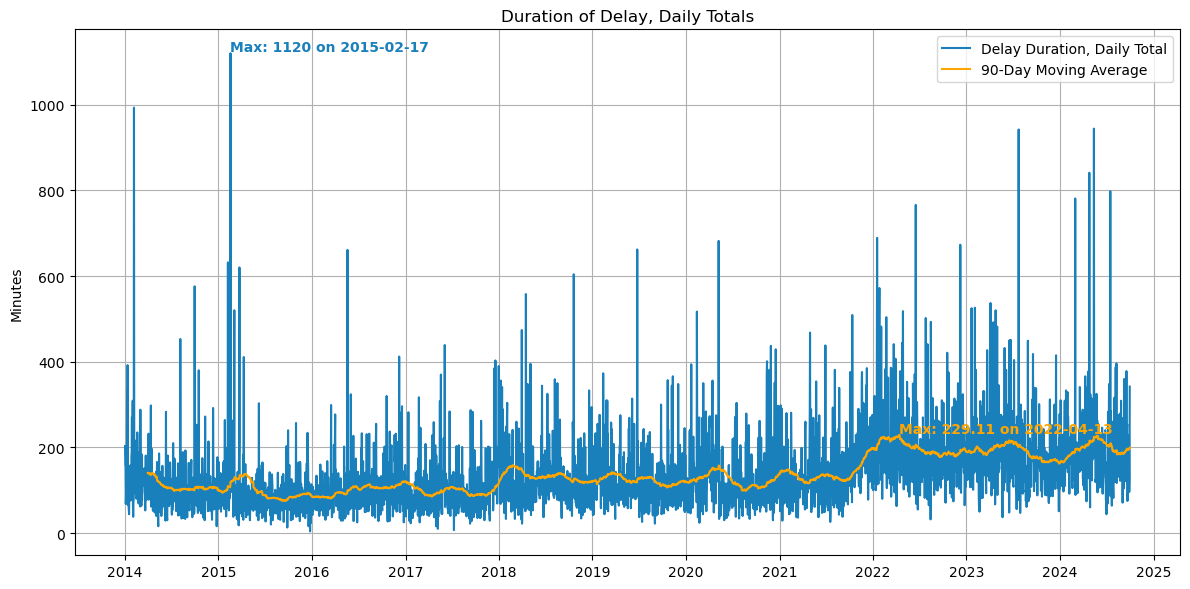

In [11]:
daily_delay_duration = df_master.groupby('Date')['Min Delay'].sum().reset_index()
daily_delay_duration['MA90'] = daily_delay_duration['Min Delay'].rolling(window = 90). mean()
fig,ax = plt.subplots(figsize = (12,6))

ax.plot(daily_delay_duration['Date'], daily_delay_duration['Min Delay'], color = '#1a80bb', label = 'Delay Duration, Daily Total')
ax.plot(daily_delay_duration['Date'], daily_delay_duration['MA90'], color = 'orange', label = '90-Day Moving Average')
ax.set_title('Duration of Delay, Daily Totals')
ax.set_ylabel('Minutes')
ax.grid(True)
ax.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# maximum data annotation
max_date = daily_delay_duration.loc[daily_delay_duration['Min Delay'].idxmax(), 'Date']
max_delay = daily_delay_duration['Min Delay'].max()
plt.annotate(f'Max: {max_delay} on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), xytext = (max_date, max_delay + 5),
             fontsize = 10, color = '#1a80bb', fontweight = 'bold')

# maximum moving average annotation
max_date = daily_delay_duration.loc[daily_delay_duration['MA90'].idxmax(), 'Date']
max_delay = daily_delay_duration['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), xytext = (max_date, max_delay + 5),
             fontsize = 10, color = 'orange', fontweight = 'bold')

fig.tight_layout()
plt.show()